temp_wh.dat + spike_time.npy -- filter -- sliding window pp --pca

In [8]:
# load npy file
import os
import numpy as np
import matplotlib.pyplot as plt

# change dir
os.chdir('/Users/xiao-zy19/Desktop/good_cs')
spike_clusters = np.load('spike_clusters.npy')
spike_times = np.load('spike_times.npy')
data = np.fromfile('temp_wh.dat', dtype=np.int16).reshape(-1, 128) #reshape((-1, 128))
channel_data = data[:, 23]
print(f'spike_clusters: {spike_clusters.shape}, \nspike_times: {spike_times.shape}, \ndata: {data.shape}')

cluster_id = 47
indices = np.where(spike_clusters == cluster_id)[0]
spike_sample_index = spike_times[indices]
spike_sample_index = np.sort(spike_sample_index)

threshold = 600
fs = 30000  # Sample rate
lowcut = 300  # High-pass filter cutoff frequency
highcut = 1000  # High cut frequency for the band-pass filter
lowcut_bp = 100  # Low cut frequency for the band-pass filter

spike_clusters: (150626, 1), 
spike_times: (150626, 1), 
data: (6166400, 128)


In [9]:
# design filters
from scipy.signal import butter, sosfilt, sosfreqz, filtfilt

# Sample rate and desired cutoff frequencies
# fs = 30000  # Sample rate
# lowcut = 600  # High-pass filter cutoff frequency
# highcut = 600  # High corner frequency for the band-pass filter
# lowcut_bp = 30  # Low corner frequency for the band-pass filter

# Butterworth High-Pass Filter
def butter_highpass(cutoff, fs, order=10):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

# Band-Pass Filter
def butter_bandpass(lowcut_bp, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut_bp / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

def apply_filter(data, b, a):
    y = filtfilt(b, a, data)
    return y

# initialize the filters
b_high, a_high = butter_highpass(lowcut, fs, order=10)
b_band, a_band = butter_bandpass(lowcut_bp, highcut, fs, order=2)

In [10]:
def slide_pp(data, window_size=300, step_size=100, peak_points=None):

    results = {"start_index": [], "peak_index": [], "peak_to_peak_value": []}
    if peak_points is None:
        for start in range(0, len(data) - window_size + 1, step_size):
            end = start + window_size
            window_data = data[start:end]

            max_val = np.max(window_data)
            min_val = np.min(window_data)
            max_index = np.argmax(window_data) + start
            min_index = np.argmin(window_data) + start

            peak_index = (max_index + min_index) // 2
            peak_to_peak = max_val - min_val

            results["start_index"].append(start)
            results["peak_index"].append(peak_index)
            results["peak_to_peak_value"].append(peak_to_peak)
    else:
        for center in peak_points:
            start = center - window_size // 2
            end = start + window_size
            window_data = data[start:end]

            max_val = np.max(window_data)
            min_val = np.min(window_data)
            max_index = np.argmax(window_data) + start
            min_index = np.argmin(window_data) + start

            peak_index = (max_index + min_index) // 2
            peak_to_peak = max_val - min_val

            results["start_index"].append(start)
            results["peak_index"].append(peak_index)
            results["peak_to_peak_value"].append(peak_to_peak)
    return results

/var/folders/rz/yg988zf56zl1lj6ngjhzkq5r0000gn/T/ipykernel_59739/313877495.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(low_freq_data[int(spike_sample_index[i])-1000:int(spike_sample_index[i])+1000])


[ 118583  164701  206722 ... 6120737 6122707 6122708]


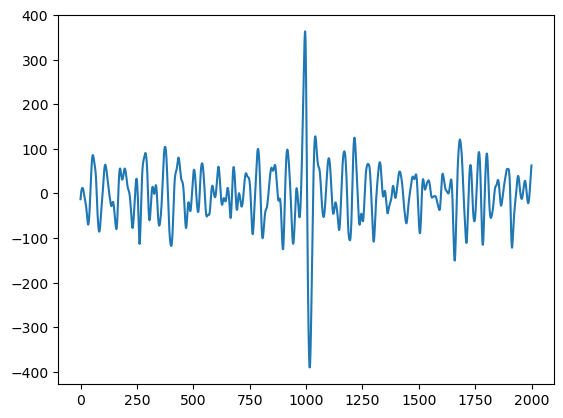

In [11]:
low_freq_data = apply_filter(channel_data, b_band, a_band)
high_freq_data = apply_filter(channel_data, b_high, a_high)

i = 10
plt.plot(low_freq_data[int(spike_sample_index[i])-1000:int(spike_sample_index[i])+1000])

results = slide_pp(low_freq_data, window_size=300, step_size=100)
peak_points = results['peak_index']
peak_values = results['peak_to_peak_value']
# peak threshold
# threshold = 300
# find the peak points that are above the threshold, along with their corresponding peak index
peak_points = [peak_points[i] for i in range(len(peak_points)) if peak_values[i] > threshold]
# peak_values = [peak_values[i] for i in range(len(peak_values)) if peak_values[i] > threshold]
peak_points = list(set(peak_points))
peak_points.sort()
peak_points = np.array(peak_points)

re_results = slide_pp(low_freq_data, window_size=300, step_size=10, peak_points=peak_points)
del peak_points, peak_values
peak_points = re_results['peak_index']
peak_values = re_results['peak_to_peak_value']
peak_points = list(set(peak_points))
peak_points.sort()
peak_points = np.array(peak_points)
print(peak_points)

In [12]:
low_pre_ms = 2
low_segment_ms = 10
high_pre_ms = 0.5
high_segment_ms = 2

low_freq_segments = []
high_freq_segments = []
labels = []

for point in peak_points:
    if point - low_pre_ms * fs / 1000 < 0 or point + low_segment_ms * fs / 1000 > len(low_freq_data):
        continue
    start_low = int(point - low_pre_ms * fs / 1000)
    end_low = int(start_low + low_segment_ms * fs / 1000)
    
    start_high = int(point - high_pre_ms * fs / 1000)
    end_high = int(start_high + high_segment_ms * fs / 1000)
    low_freq_segments.append(low_freq_data[start_low:end_low])
    high_freq_segments.append(high_freq_data[start_high:end_high])
    
    # 1 if the peak is near a ’complex' spike, 0 otherwise
    is_near_spike = any(abs(spike_point - point) <= 200 for spike_point in spike_sample_index)
    labels.append(0 if is_near_spike else 1)
    
low_freq_segments = np.array(low_freq_segments)
high_freq_segments = np.array(high_freq_segments)

# align the high_freq_segments
for i, segment in enumerate(high_freq_segments):
    peak_index = np.argmax(segment)  # Find the peak index
    start_adjusted = max(0, peak_index - int(2 * fs / 1000))  # Adjust start
    end_adjusted = min(len(segment), peak_index + int(5 * fs / 1000))  # Adjust end index
    high_freq_segments[i] = segment[start_adjusted:end_adjusted]

In [13]:
from sklearn.decomposition import PCA

# Flatten the segments
low_freq_vectors = low_freq_segments.reshape(low_freq_segments.shape[0], -1)
high_freq_vectors = high_freq_segments.reshape(high_freq_segments.shape[0], -1)
print(f'low freq vectors shape: {low_freq_vectors.shape}, high freq vectors shape: {high_freq_vectors.shape}')

# Perform PCA
pca_low = PCA(n_components=2)
pca_high = PCA(n_components=2)

low_freq_pca = pca_low.fit_transform(low_freq_vectors)
high_freq_pca = pca_high.fit_transform(high_freq_vectors)
print(f'low freq pca shape: {low_freq_pca.shape}, high freq pca shape: {high_freq_pca.shape}')

low freq vectors shape: (2961, 300), high freq vectors shape: (2961, 60)
low freq pca shape: (2961, 2), high freq pca shape: (2961, 2)


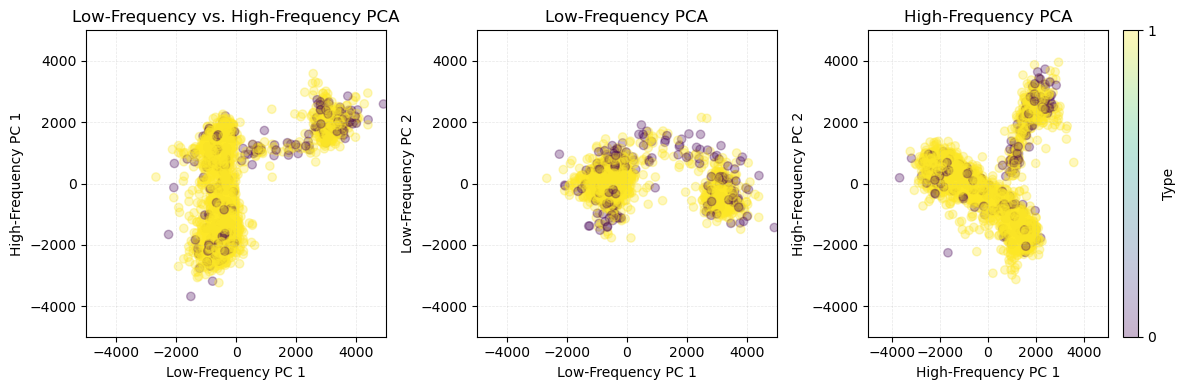

In [14]:
import matplotlib.pyplot as plt

# Plotting PCA results for low-frequency data
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(low_freq_pca[:, 0], high_freq_pca[:, 0], alpha=0.3, c=labels)
plt.title('Low-Frequency vs. High-Frequency PCA')
plt.xlabel('Low-Frequency PC 1')
plt.ylabel('High-Frequency PC 1')
plt.xlim(-5000, 5000)
plt.ylim(-5000, 5000)
plt.grid(linestyle='--', linewidth=0.5, alpha=0.3)

plt.subplot(1, 3, 2)
plt.scatter(low_freq_pca[:, 0], low_freq_pca[:, 1], alpha=0.3, c=labels)
plt.title('Low-Frequency PCA')
plt.xlabel('Low-Frequency PC 1')
plt.ylabel('Low-Frequency PC 2')
plt.xlim(-5000, 5000)
plt.ylim(-5000, 5000)
plt.grid(linestyle='--', linewidth=0.5, alpha=0.3)

plt.subplot(1, 3, 3)
plt.scatter(high_freq_pca[:, 0], high_freq_pca[:, 1], alpha=0.3, c=labels)
plt.title('High-Frequency PCA')
plt.xlabel('High-Frequency PC 1')
plt.ylabel('High-Frequency PC 2')
plt.xlim(-5000, 5000)
plt.ylim(-5000, 5000)
plt.grid(linestyle='--', linewidth=0.5, alpha=0.3)

plt.colorbar(label='Type', ticks=[0, 1, 2])
plt.tight_layout()
plt.show()